In [26]:
import os
from glob import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nptdms import TdmsFile as TF
import datetime
from datetime import timedelta as td
%matplotlib inline



class MHDPlots(object):
    def __init__(self, ):
        self.samples = []
        self.pathnames = []
        self.imports = {}
        self.data = {}
        self.tracks = {}
        
        ##samples is a list of strings, the samples names
        ##pathnames is the full pathnames to get to each tdms file (there maybe multiple tdms files associated to different samples)
        ##imports is a dictionary, using the pathnames as the word and the imported tdms file as its definition
        ##           this step is necessary as importing the data is the longest process, but pulling data to arrays is almost immediate
        ##data is a dictionary, using the pathnames as the word and a 2D array with all data stored, useful for plotting
        ##tracks is meant to track what data has already been pulled from the imported file, and track what position in the data array certain data are
        ##           tracks uses channelnames as the word and an integer as its definition
        
        
    def set_path(self, path):
        samples = self.samples
        pathnames = self.pathnames
        for file in os.listdir(path):
            samples = np.append(samples, str(file))
        for sample in samples:
            this = glob(path+"\\"+sample+"\\*_together.tdms")
            pathnames = np.append(pathnames, this)
        self.pathnames = pathnames    
        self.samples = samples
        return
    
        ##sets the path to the main folder with subfolders and tdms files in those subfolders
        ##uses the names of folders as samples and filepaths as pathnames
    
    def importdata(self, string):
        #Will import all data in the defined file path with substring input
        pathnames = self.pathnames
        imports = self.imports
        for pathname in pathnames:
            if string in pathname:
                imports[pathname] = TF(pathname)
        self.imports = imports
        self.get_times()
        return
    
        ##imports tdms files that contain the given string. for example: the molybdenum rod experiments had 9mm, 11mm, and 13mm runs
        ##folder and file paths were organized as such
        ##runs get_times(), makes it easier to stack arrays of data and line them up with time
    
    def get_times(self, ):
        data = self.data
        imports = self.imports
        tracks = self.tracks
        track = "Time"
        self.get_data(track)
        self.data = data
        self.tracks = tracks
        return
        
        ##Fills the data dictionary with initial arrays of time, to stack with other data in future
    
    def get_motor(self,):
        motortrack = "motor A"
        self.get_data(motortrack)
        return
    
        ##Calls motor position from motor A for current set up
        
    def get_tc(self, ):
        tctrack = "T_Sample (Arith. Mean)"
        self.get_data(tctrack)
        ##run get data with thermocouple data from the sample holder    
        return
    
    def get_blackbody(self,):
        tracks = self.tracks
        data = self.data
        
        ct1 = "Color Temp 2-3"
        ct2 = "Color Temp 1-3"
        ct3 = "Color Temp 1-2"
        ctavg = "Avg Color Temp"
        self.get_data(ct1)
        self.get_data(ct2)
        self.get_data(ct3)
        
        for sample in data:
            temp1 = data[sample][tracks[ct1]]
            temp2 = data[sample][tracks[ct2]]
            temp3 = data[sample][tracks[ct3]]
            ctavg = np.mean(np.vstack((temp1,temp2,temp3)),0)
            self.store_data(sample, ctavg, "Color Temp Avg.")
        return
        ##gets all two color temperatures and stores them, then calculates the averages and stores that as well
    
    def get_custom(self, channelname):
        tctrack = channelname
        self.get_data(tctrack)
        return
        ##allows you to get data from a custom channel, given an input channel name
    
    
    def get_data(self, track):
        data = self.data
        imports = self.imports
        tracks = self.tracks
        
        if track not in self.tracks:        
            for string in data:
                file = imports[string]
                groups = file.groups()
                for group in groups:
                    channels = file.group_channels(group)
                    for channel in channels:
                        if track == channel.channel:
                            subdata = channel.data
                            self.store_data(string, subdata)
                tracks[track] = len(data[string])-1
        else:
            print("Error: trying to store duplicate data")
            
        self.tracks = tracks
        return
        
        ##searches all groups for a channel with the channelname
        ##gets data from this channel, runs store_data() to update the respective data array
    
    def store_data(self, string, array):
        data = self.data
        
        length = len(np.transpose(data[string]))
        if len(array) != length:
            array = self.resize(array, length)
        data[string] = np.vstack((data[string], array))
        
        self.data = data
        return
        
        ##as implied, stores data. stacks the array with time, updates the data dictionary, and stores data position in tracks
        ##the else statement prevents the data arrays from storing duplicate data
    
    def align(self, channel="motor A"):
        data = self.data
        tracks = self.tracks
        track = "Relative Time"
        if track not in tracks:
            for sample in data:
                time = data[sample][tracks["Time"]]
                motor = data[sample][tracks[channel]]
                start = np.where(motor[1:]-motor[:-1]>.2)
                start = start[0][1]
                timerel = np.zeros_like(time)
                for i, val in enumerate(time):
                    timerel[i] = (time[i]-time[start]).total_seconds()
                self.store_data(sample, timerel, "Relative Time")
        return
        ##Creates a relative time array, for comparing different samples, and aligns the start time of burning the sample
        ##    with the motors position
        ##In future experiments, the align function might be used with other channels, and is anticipated to be made more general
    
    
    def plot_samples(self, channel, sample="all"):
        data = self.data
        tracks = self.tracks
        axes = plt.gca()
        val = False
        if channelname not in tracks:
            print("Data has not been called. Please use get_custom('channelname')")
        else:
            if sample == "all":
                for string in data:
                    plt.plot(data[string][tracks["Time"]], data[string][tracks[channelname]], label = sample)
            
            else:
                for string in data:
                    if sample in string:
                        plt.plot(data[string][tracks["Time"]], data[string][tracks[channelname]], label = sample)
                        val = True
        if val == False:
            print("Sample data has not been imported. Please use importdata(filename substring)")
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return
    
    def plot_channels(self, channel, sample):
        data = self.data
        tracks = self.tracks
        axes = plt.gca()
        if channelname not in tracks:
            print("Data has not been called. Please use get_custom('channelname')")
        else:
            for string in data:
                plt.plot(data[string][tracks["Time"]], data[string][tracks[channelname]], label = sample)
            else:
                for string in data:
                    if sample in string:
                        plt.plot(data[string][tracks["Time"]], data[string][tracks[channelname]], label = sample)
        if val == False:
            print("Sample data has not been imported. Please use importdata(filename substring)")
        
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        return

   
    def resize(self, arr, length):
        if len(arr)>length:
            arr = arr[1:]
        elif len(arr)<length:
            arr = np.append(arr, 0)
        else:
            print("error")
        return arr   

In [27]:
a = MHDPlots()
a.set_path("D:\\Data\\MolyRod")

In [28]:
a.importdata("13mm_together.tdms")

In [29]:
a.get_motor()

In [5]:
a.plot("Color Temp 1-2", "all")

Data has not been called. Please use get_custom('channelname')


In [7]:
a.get_custom("Color Temp 1-2")

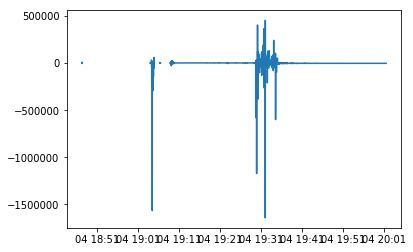

In [9]:
a.plot("Color Temp 1-2", "all")

In [34]:
a.get_blackbody()

AttributeError: 'float' object has no attribute 'dtype'

In [68]:

data = {}
data["this"]= 9
data["that"] = 10
data['thisone'] = 13
for string in data:
    for sample in string:
        print (data[string])


9
9
9
9
10
10
10
10
13
13
13
13
13
13
13


In [19]:
dictionary = a.data

In [25]:
dictionary[string][a.tracks['Color Temp 1-2']]

array([nan, nan, nan, ..., -2699.583823525356, -2669.5988384567468,
       -2855.809704437397], dtype=object)